In [8]:
import gymnasium as gym
import torch
from tqdm import tqdm
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import seaborn as sns
import torch.nn as nn

In [2]:
env = gym.make("FrozenLake-v1", is_slippery=True)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size=16, hidden_size=32, output_size=4):
        super().__init__()
        # Only 2 hidden units for easy 2D visualization!
        self.hidden = nn.Linear(input_size, hidden_size, bias=False)
        self.output = nn.Linear(hidden_size, output_size, bias=False)
        
    def forward(self, x):
        x = self.hidden(x)
        x = nn.functional.relu(x)  # Nonlinearity
        x = self.output(x)
        return x


In [44]:
def get_policy_outputs(model, env):
    obs = torch.eye(env.observation_space.n)  # One-hot encoding of states
    with torch.no_grad():
        outputs = model(obs).numpy()
    return np.argmax(outputs, axis=1)

In [21]:
def train_with_tracking(env_name="FrozenLake-v1", num_episodes=100000):
    env = gym.make(env_name, is_slippery=True)
    network = MLP()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
    
    # Store parameter trajectories and performance
    parameter_history = []
    success_history = []
    
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        if not isinstance(state, int):
            state = state[0]
        done = False
        total_reward = 0
        
        # Store current parameters
        current_params = np.concatenate([
            network.hidden.weight.detach().flatten().numpy(),
            network.output.weight.detach().flatten().numpy()
        ])
        parameter_history.append(current_params.copy())
        
        while not done:
            # One-hot encode state
            state_onehot = torch.zeros(16)
            state_onehot[state] = 1.0
            
            # Get action probabilities
            logits = network(state_onehot)
            probs = torch.softmax(logits, dim=0)
            action = torch.multinomial(probs, 1).item()
            
            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            if not isinstance(next_state, int):
                next_state = next_state[0]
            done = done or truncated
            
            # Simple REINFORCE update
            log_prob = torch.log(probs[action])
            loss = -log_prob * reward
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            state = next_state
            total_reward += reward
        
        success_history.append(1 if total_reward > 0 else 0)
    
    return parameter_history, success_history, network

In [22]:
param_hist, success_hist, net = train_with_tracking()

100%|██████████| 100000/100000 [07:43<00:00, 215.89it/s]


In [25]:
succ_inds = [i for i, s in enumerate(success_hist) if s == 1]

In [32]:
succ_inds[-1]

99790

In [46]:
policy_vecs = []

for i in range(len(param_hist)):
    # Load parameters into network
    param_vector = param_hist[i]
    hidden_size = net.hidden.weight.numel()
    net.hidden.weight.data = torch.tensor(param_vector[:hidden_size].reshape(net.hidden.weight.shape), dtype=torch.float32)
    net.output.weight.data = torch.tensor(param_vector[hidden_size:].reshape(net.output.weight.shape), dtype=torch.float32)
    
    # Get policy outputs
    policy_output = get_policy_outputs(net, env)
    policy_vecs.append(policy_output.flatten())

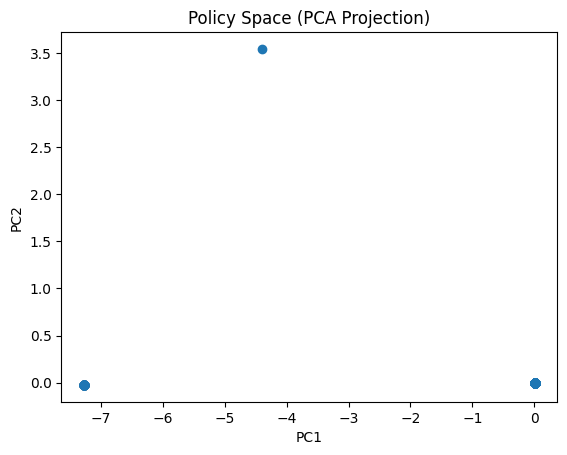

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(policy_vecs)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("Policy Space (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

c:\Users\Rohit\Documents\Work\Projects\RL\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Rohit\Documents\Work\Projects\RL\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rohit\Documents\Work\Projects\RL\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\

Text(0.5, 1.0, 'Policy Space (t-SNE Projection)')

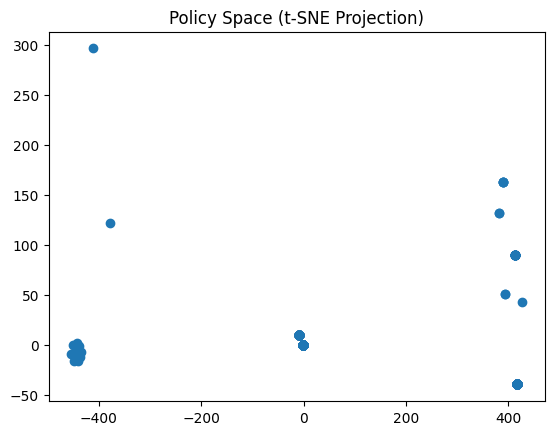

In [50]:
tsne = TSNE(n_components=2).fit_transform(np.asarray(policy_vecs))
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.title("Policy Space (t-SNE Projection)")

In [55]:
succ_policy_vecs = []

for i in succ_inds:
    # Load parameters into network
    param_vector = param_hist[i]
    hidden_size = net.hidden.weight.numel()
    net.hidden.weight.data = torch.tensor(param_vector[:hidden_size].reshape(net.hidden.weight.shape), dtype=torch.float32)
    net.output.weight.data = torch.tensor(param_vector[hidden_size:].reshape(net.output.weight.shape), dtype=torch.float32)
    
    # Get policy outputs
    policy_output = get_policy_outputs(net, env)
    succ_policy_vecs.append(policy_output.flatten())

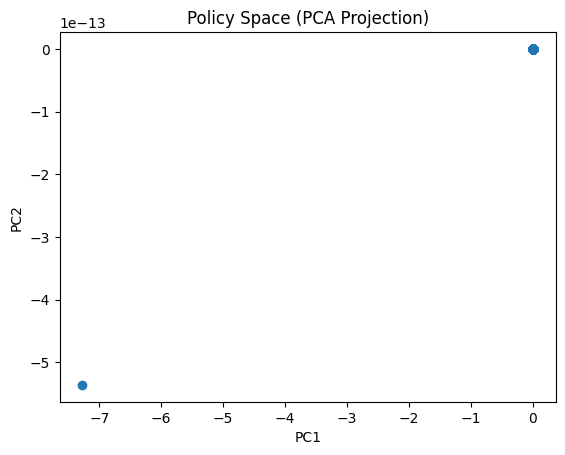

In [56]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(succ_policy_vecs)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("Policy Space (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Text(0.5, 1.0, 'Policy Space (t-SNE Projection)')

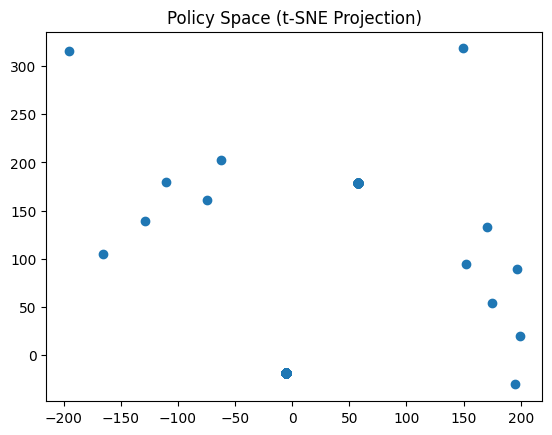

In [59]:
tsne = TSNE(n_components=2).fit_transform(np.asarray(succ_policy_vecs))
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.title("Policy Space (t-SNE Projection)")